# Análise de séries temporais

## Análise por ano e mês

Análise de reviews realizadas nos últimos anos. Verificando se ocorre sazonalidade no período de escrita dos reviews.

In [ ]:
!pip install autots
!pip install cmdstanpy>=0.9.5
!pip install prophet

In [3]:
import pandas as pd
from google.colab import drive
from autots import AutoTS
import matplotlib.pyplot as plt
from prophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_reviews = pd.read_csv('drive/My Drive/Colab Notebooks/TCC/dataset_completed.csv')

In [6]:
def parse_df(dataset):
  """Parse the dataset to the expected output to autoTs models"""
  grouped_ds = dataset.groupby(["year", "month"])
  parsed_df = pd.DataFrame(columns=["date", "reviews_count"])
  for key, item in grouped_ds:
    parsed_df = parsed_df.append({"date":f'{key[0]}-{key[1]}', "reviews_count":len(item)}, ignore_index=True)

  parsed_df['date'] = pd.to_datetime(parsed_df['date'], infer_datetime_format=True, format='%y%m')
  parsed_df['reviews_count'] = pd.to_numeric(parsed_df["reviews_count"])
  return parsed_df

In [7]:
POSITIVE = 1
NEGATIVE = 0

#All Reviews
df_full_parsed = parse_df(df_reviews.loc[df_reviews["year"] <= 2019])

# ----- Florida ------

#Florida - All Reviews
df_florida_reviews = df_reviews.loc[(df_reviews["branch"] == "Universal Studios Florida") & (df_reviews["year"] <= 2019)]
df_florida_reviews_parsed = parse_df(df_florida_reviews)

#Florida - Negative Reviews
df_florida_neg_reviews = df_florida_reviews.loc[df_florida_reviews["label"] == NEGATIVE]
df_florida_neg_reviews_parsed = parse_df(df_florida_neg_reviews)

#Florida - Positive Reviews
df_florida_pos_reviews = df_florida_reviews.loc[df_florida_reviews["label"] == POSITIVE]
df_florida_pos_reviews_parsed = parse_df(df_florida_pos_reviews)

# ----- Japan ------

#Japan - All Reviews
df_japan_reviews = df_reviews.loc[(df_reviews["branch"] == "Universal Studios Japan") & (df_reviews["year"] <= 2019)]
df_japan_reviews_parsed = parse_df(df_japan_reviews)

#Japan - Negative Reviews
df_japan_neg_reviews = df_japan_reviews.loc[df_japan_reviews["label"] == NEGATIVE]
df_japan_neg_reviews_parsed = parse_df(df_japan_neg_reviews)

#Japan - Positive Reviews
df_japan_pos_reviews = df_japan_reviews.loc[df_japan_reviews["label"] == POSITIVE]
df_japan_pos_reviews_parsed = parse_df(df_japan_pos_reviews)

# ----- Singapore ------

#Singapore - All Reviews
df_singapore_reviews = df_reviews.loc[(df_reviews["branch"] == "Universal Studios Singapore") & (df_reviews["year"] <= 2019)]
df_singapore_reviews_parsed = parse_df(df_singapore_reviews)

#Singapore - Negative Reviews
df_singapore_neg_reviews = df_singapore_reviews.loc[df_singapore_reviews["label"] == NEGATIVE]
df_singapore_neg_reviews_parsed = parse_df(df_singapore_neg_reviews)

#Singapore - Positive Reviews
df_singapore_pos_reviews = df_singapore_reviews.loc[df_singapore_reviews["label"] == POSITIVE]
df_singapore_pos_reviews_parsed = parse_df(df_singapore_pos_reviews)

In [14]:
def train_and_predict(df):
  model = AutoTS(forecast_length=30, frequency='infer', 
                  ensemble='simple', drop_data_older_than_periods=100)
  model = model.fit(df, date_col='date', value_col='reviews_count', id_col=None)
  prediction = model.predict()
  forecast = prediction.forecast
  return forecast

def plot_prediction(temp_df, forecast):
  temp_df['reviews_count'].plot(figsize=(12,8), title= 'Reviews Count Over the Years', fontsize=20, label='Train')
  forecast['reviews_count'].plot(figsize=(12,8), title= 'Reviews Count Over the Years', fontsize=20, label='Test')
  plt.legend()
  plt.grid()
  plt.savefig("drive/My Drive/Colab Notebooks/TCC/latest_prediction.png")
  plt.show()

def predict_and_plot_model_autoTS(dataset):
  df = dataset[["date", "reviews_count"]]
  df["date"] = pd.to_datetime(df.date)
  temp_df = df.set_index('date')
  #temp_df["reviews_count"].plot(figsize=(12, 8), title="Reviews_Count x Written_Date", fontsize=20, label="Reviews_Count")
  forecast = train_and_predict(df)
  plot_prediction(temp_df, forecast)

In [ ]:
df = df_florida_pos_reviews_parsed[["date", "reviews_count"]]
df["date"] = pd.to_datetime(df.date)
temp_df = df.set_index('date')
forecast = train_and_predict(df)

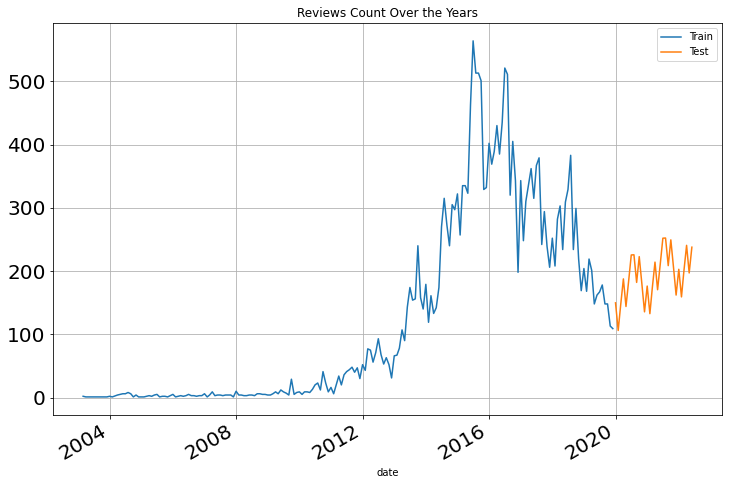

In [16]:
plot_prediction(temp_df, forecast)

In [27]:
def get_limit_index(dataset):
  """Get the limit index for train and model of the dataset. Considering 75%"""
  return int(0.75 * len(dataset))

def train_with_prophet_model(dataset):
  """Train the data with Prophet model"""
  dataset.columns = ["ds", "y"]
  prophet = Prophet(weekly_seasonality=True)
  limit_index = get_limit_index(dataset)
  train = dataset[:limit_index]
  test = dataset[limit_index:]
  prophet.fit(train)
  return prophet
  
def predict_with_prophet_model(prophet, periods):
  """Make a prediction with prophet model and periods (param)."""
  future = prophet.make_future_dataframe(periods=periods)
  forecast = prophet.predict(future)
  components = prophet.plot_components(forecast)

In [28]:
prophet = train_with_prophet_model(df_florida_pos_reviews_parsed)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


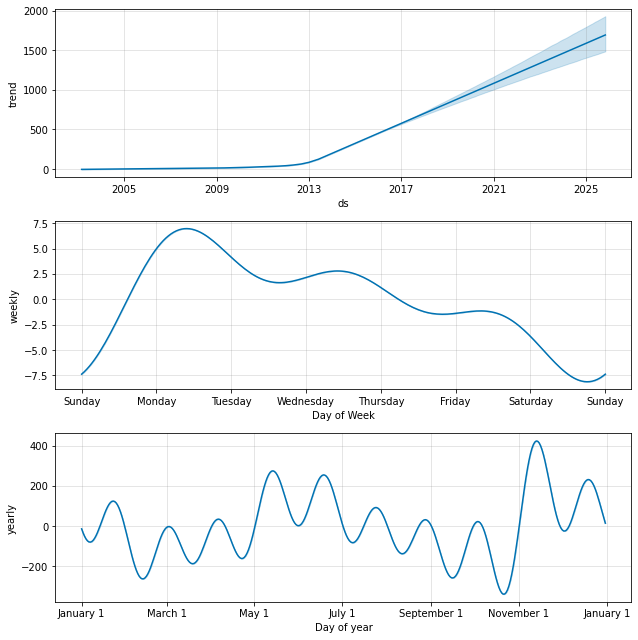

In [29]:
predict_with_prophet_model(prophet=prophet, periods=3650)